In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup


# pd.set_option('display.max_colwidth')

In [3]:
# bad songs dataframe
bad_songs = pd.read_csv('datasets/bad_cleaned2.csv')
bad_songs

,artist,song,lyrics
0,YG,BAND DRUM (feat. A$AP Rocky),I mix the 4Hunnid with the designer Stay lace...
1,Chris Cooq,Lactose,I came to rule this stage with that Budden swa...
2,Chris Cooq,Same - Original mix,Gorillaz - Song Machine Episode 7 - 4/4 mxmto...
3,Curbo,Debauchery - Original mix,"Learning is, indeed, a very great and a very..."
4,G Herbo,Bon appétit,"Young nigga eatin', uh, bon appetit, uh Messe..."
...,...,...,...
3468,King John,Mismatched,"We've been dispatched by God, sent to warn the..."
3469,Buck Meek,Cannonball!,"Beats me down by the pool, sweet Suzy, summer’..."
3470,Big Beats,Young Forever (Instrumental),Proving himself in the booth was just the be...
3471,Big Beats,Escape (Instrumental),"I'm just me, I can't be different Thoug..."


In [10]:
average_length = bad_songs['lyrics'].str.len().mean()
average_words = bad_songs['lyrics'].str.split().apply(len).mean()
average_words

6401.709473078031

In [5]:
# good songs dataframe
good_songs = pd.read_csv('datasets/good_cleaned.csv')
good_songs = good_songs[['artist','song','lyrics']].copy()
good_cut = good_songs[:-1400]
good_cut

,artist,song,lyrics
0,sam the sham and the pharaohs,wooly bully,sam the sham miscellaneous wooly bully wooly b...
1,four tops,i cant help myself sugar pie honey bunch,sugar pie honey bunch you know that i love yo...
2,we five,you were on my mind,when i woke up this morning you were on my mi...
3,the righteous brothers,youve lost that lovin feelin,you never close your eyes anymore when i kiss...
4,petula clark,downtown,when youre alone and life is making you lonel...
...,...,...,...
3461,dave matthews band,the space between,you cannot quit me so quickly is no hope in y...
3462,faith hill,there youll be,when i think back on these times and the drea...
3463,musiq soulchild,love,love so many things ive got to tell you but i...
3464,112,its over now,what is this numbers in your pocket i remembe...


In [12]:
average_length2 = good_cut['lyrics'].str.len().mean()
average_words2 = good_cut['lyrics'].str.split().apply(len).mean()
average_words2

281.6543566070398

In [13]:
print('characters discrepancy: ',average_length / average_length2)
print('words discrepancy: ',average_words / average_words2)

characters discrepancy:  26.885795921435424
words discrepancy:  22.728955980644056


In [30]:
# combined dataframe
main = pd.concat([good_cut, bad_songs], ignore_index=True)

In [33]:
# text cleaning 1
def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove punctuation
    cleaned_text = re.sub(r'[.,!?\\-]', '', text)

    return cleaned_text

main['lyrics'] = main['lyrics'].apply(clean_text)

In [31]:
# lyrics cleaning 2 - normalization
from unicodedata import normalize
# Convert lyrics to lowercase
main['lyrics'] = main['lyrics'].str.lower()

# Remove accents and diacritical marks
main['lyrics'] = main['lyrics'].apply(lambda x: normalize('NFKD', x).encode('ASCII', 'ignore').decode('utf-8'))

# Expand contractions
contractions = {
    "don't": "do not",
    "can't": "cannot",
    # Add more contractions and their expanded forms as needed
}

def expand_contractions(lyrics):
    for contraction, expansion in contractions.items():
        lyrics = re.sub(r"\b" + contraction + r"\b", expansion, lyrics)
    return lyrics

main['lyrics'] = main['lyrics'].apply(expand_contractions)

In [34]:
# result = main['lyrics'].str.contains('\.').sum()
main

,artist,song,lyrics
0,sam the sham and the pharaohs,wooly bully,sam the sham miscellaneous wooly bully wooly b...
1,four tops,i cant help myself sugar pie honey bunch,sugar pie honey bunch you know that i love yo...
2,we five,you were on my mind,when i woke up this morning you were on my mi...
3,the righteous brothers,youve lost that lovin feelin,you never close your eyes anymore when i kiss...
4,petula clark,downtown,when youre alone and life is making you lonel...
...,...,...,...
6934,King John,Mismatched,we've been dispatched by god sent to warn thes...
6935,Buck Meek,Cannonball!,beats me down by the pool sweet suzy summers g...
6936,Big Beats,Young Forever (Instrumental),proving himself in the booth was just the be...
6937,Big Beats,Escape (Instrumental),i'm just me i cannot be different thoug...


In [54]:
result = bad_songs['lyrics'].str.contains('also').sum()
result

2924

In [35]:
'''splitting'''
# Create a new column 'label' with 1 for good songs and 0 for bad songs
main['label'] = (main['lyrics'].isin(good_songs['lyrics'])) * 1

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(main['lyrics'], main['label'], random_state=42)

y_test = y_test.values.reshape(-1, 1)

In [40]:
import nltk
from nltk.corpus import stopwords

# Download the English stop words from NLTK
nltk.download('stopwords')
english_stop_words = stopwords.words('english')

# Get the Spanish stop words from NLTK
nltk.download('stopwords')
spanish_stop_words = stopwords.words('spanish')

# Combine the stop words into a single list
stop_words = english_stop_words + spanish_stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kubad\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kubad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
vect = CountVectorizer(min_df=5, stop_words=stop_words, ngram_range=(1, 2)) #stop_words=stop_words

text_train = vect.fit_transform(X_train)
text_test = vect.transform(X_test)

In [10]:
# Running logistic regression with different ngram values
ngram_lengths = [1, 2, 3]  # Example: Unigrams, Bigrams, Trigrams

# Iterate over different n-gram lengths
for n in ngram_lengths:
    # Create the CountVectorizer with the specified n-gram length
    vect = CountVectorizer(min_df=5, ngram_range=(1, n))

    # Apply tokenization and vectorization on the 'lyrics' column
    text_train = vect.fit_transform(X_train)
    text_test = vect.transform(X_test)

    # Create a logistic regression model
    lr = LogisticRegression()

    # Perform cross-validation on the training data and compute the mean accuracy
    scores = cross_val_score(lr, text_train, y_train, cv=5)
    mean_accuracy = scores.mean()

    # Print the results for the current n-gram length
    print(f"Accuracy with n-gram length {n}: {mean_accuracy}")

    # Fit the logistic regression model on the full training data and evaluate on the test data
    lr.fit(text_train, y_train)
    test_accuracy = lr.score(text_test, y_test)
    print(f"Test Accuracy with n-gram length {n}: {test_accuracy}")

# n-gram = 1: accuracy 0.9851294644284574, test accuracy 0.9908872901678657
# n-gram = 2: accuracy 0.9884874180655476, test accuracy 0.9932853717026379
# n-gram = 3: accuracy 0.9881676738609114, test accuracy 

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\kubad\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\kubad\AppData\Local\Temp\ipykernel_13096\652496380.py", line 10, in <module>
    text_train = vect.fit_transform(X_train)
  File "c:\Users\kubad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py", line 1338, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
  File "c:\Users\kubad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py", line -1, in _count_vocab
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\kubad\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 1997, in showtraceback


In [11]:
print("text_train:\n{}".format(repr(text_train)))
#shape of our text_train is 8106x327664 - vocabulary contains 327664 entries (features) stored as SciPy sparse matrix
#shape after constraint to have appearance in at least 5 documents, shrinks to 108184 features

text_train:
<6675x278978 sparse matrix of type '<class 'numpy.int64'>'
	with 3696204 stored elements in Compressed Sparse Row format>


In [57]:
# Create a logistic regression object and fit the model on the training data
lr = LogisticRegression()
lr.fit(text_train, y_train)

# Evaluate the model on the test data
score = lr.score(text_test, y_test)
print("Accuracy:", score)

scores = cross_val_score(lr, text_train, y_train, cv=5)
scores

c:\Users\kubad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9711815561959655


c:\Users\kubad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kubad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

KeyboardInterrupt: 

c:\Users\kubad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


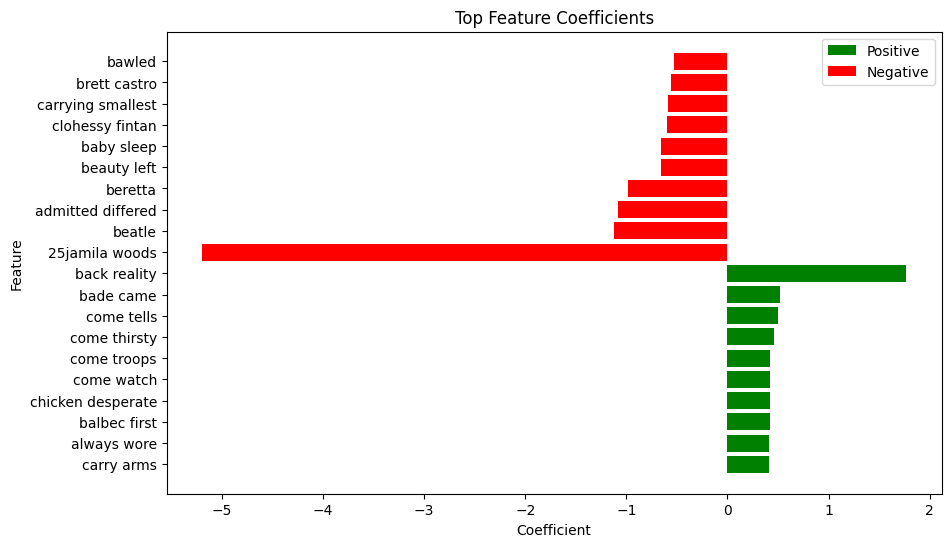

In [56]:
import matplotlib.pyplot as plt

# Retrieve feature names and coefficients
feature_names = vect.get_feature_names()
coefficients = lr.coef_[0]

# Create a dictionary of feature names and coefficients
feature_coefficients = dict(zip(feature_names, coefficients))

# Sort the feature coefficients based on their values
sorted_coefficients = sorted(feature_coefficients.items(), key=lambda x: x[1])

# Separate positive and negative coefficients
positive_coefficients = [(feature, coef) for feature, coef in sorted_coefficients if coef > 0]
negative_coefficients = [(feature, coef) for feature, coef in sorted_coefficients if coef < 0]

# Get the top N positive and negative coefficients
top_positive_features = positive_coefficients[-10:]  # Change the number as per your preference
top_negative_features = negative_coefficients[:10]  # Change the number as per your preference

# Extract feature names and coefficients
top_positive_feature_names = [feature for feature, _ in top_positive_features]
top_positive_feature_coefficients = [coefficient for _, coefficient in top_positive_features]
top_negative_feature_names = [feature for feature, _ in top_negative_features]
top_negative_feature_coefficients = [coefficient for _, coefficient in top_negative_features]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_positive_feature_names, top_positive_feature_coefficients, color='green', label='Positive')
plt.barh(top_negative_feature_names, top_negative_feature_coefficients, color='red', label='Negative')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top Feature Coefficients')
plt.legend()
plt.show()

